<div align="center">
    <img src="images/divvy_vanner.avif" width="450">
</div>

# Chicago Divvy/Lyft Bicycle Subscriber Analysis
### Author: [Sean Harris](https://www.linkedin.com/in/sean-harris-data-sci-and-finance/)
### Note: This is for academic purposes only.

August 22, 2023

* [Presentation](https://github.com/smharris312/Divvy_Chicago_Data_Analysis/blob/main/Chicago%20Lyft%20Divvy%20Presentation.pdf)

# Business Understanding

## Stakeholders:
* Chicago Department of Transportation
* Lyft/Divvy

## Background:
[Construction on the I-90/Kennedy Expressway in Chicago](https://www.nbcchicago.com/traffic/years-long-construction-project-begins-monday-kennedy-expressway/3098384/) has broken ground on a multiyear construction project to rehabilitate the bridge structures, road surface and modernize the signage. The $150 million project is focused on a 7.5 mile stretch leading into the downtown loop and is expected to be completed in the summer of 2025. Since the project has begun, [traffic congestion has diverted to surface streets leading to gridlock](https://www.cbsnews.com/chicago/news/kennedy-construction-trickle-down-traffic-jams/).

## Goal:
Using public Lyft/Divvy ride data, this analysis will develop a model to accurately predict Divvy Subscribers in order to inform marketing decisions aimed at increasing riders and reducing surface street traffic congestion.

# Data Overview

The dataset used for this analysis is publicly available on the [City of Chicago Data portal](https://data.cityofchicago.org/Transportation/Divvy-Trips/fg6s-gzvg).

#### Features of Interest:

 * from_station_id - the station that the ride was initiated from
 * gender - Male/Female/No Response                   
 * age_2019 - age of the rider in 2019

#### Target:         
 * user_type - Subscriber equals 1 and Customer equals 0           

#### Data Limitations:
* Only includes 2019 data
* Missing data for age and gender 
* Target variable is imbalanced favoring Subscribers

### Import Libraries and Load the Dataset

In [59]:
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, recall_score
from sklearn.tree import DecisionTreeClassifier
# Unable to run these models on my computer without running into a memory error. Evaluate these models in a future iteration.
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import gc
from imblearn.over_sampling import SMOTE
from matplotlib.ticker import FuncFormatter

In [60]:
# Read in the data
df = pd.read_csv('data/Divvy_Trips_2019.csv')

# Make column headers lower case and replace spaces with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')

# See all columns and rows when using descriptive methods during EDA
pd.set_option('display.max_columns', None)

## EDA

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818004 entries, 0 to 3818003
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   trip_id                 int64  
 1   start_time              object 
 2   stop_time               object 
 3   bike_id                 int64  
 4   trip_duration           int64  
 5   from_station_id         int64  
 6   from_station_name       object 
 7   to_station_id           int64  
 8   to_station_name         object 
 9   user_type               object 
 10  gender                  object 
 11  birth_year              float64
 12  from_latitude           float64
 13  from_longitude          float64
 14  from_location           object 
 15  to_latitude             float64
 16  to_longitude            float64
 17  to_location             object 
 18  boundaries_-_zip_codes  float64
 19  zip_codes               float64
 20  community_areas         float64
 21  wards                   float64

In [62]:
df.isna().sum()

trip_id                        0
start_time                     0
stop_time                      0
bike_id                        0
trip_duration                  0
from_station_id                0
from_station_name              0
to_station_id                  0
to_station_name                0
user_type                      0
gender                    559206
birth_year                538751
from_latitude                 46
from_longitude                46
from_location                 46
to_latitude                  261
to_longitude                 261
to_location                  261
boundaries_-_zip_codes     24023
zip_codes                     46
community_areas            24023
wards                      24023
dtype: int64

In [63]:
df.head(10)

,trip_id,start_time,stop_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,gender,birth_year,from_latitude,from_longitude,from_location,to_latitude,to_longitude,to_location,boundaries_-_zip_codes,zip_codes,community_areas,wards
0,25962904,12/31/2019 11:57:17 PM,12/31/2019 11:59:18 PM,5930,120,256,Broadway & Sheridan Rd,240,Sheridan Rd & Irving Park Rd,Subscriber,Male,1982.0,41.952833,-87.649993,POINT (-87.649993 41.952833),41.954245,-87.654406,POINT (-87.654406 41.954245),53.0,21186.0,57.0,39.0
1,25962903,12/31/2019 11:57:11 PM,01/01/2020 12:05:45 AM,2637,514,623,Michigan Ave & 8th St,52,Michigan Ave & Lake St,Subscriber,Female,1970.0,41.872773,-87.623981,POINT (-87.623981 41.872773),41.886024,-87.624117,POINT (-87.624117 41.886024),35.0,14913.0,38.0,10.0
2,25962902,12/31/2019 11:57:05 PM,01/01/2020 12:05:46 AM,863,520,623,Michigan Ave & 8th St,52,Michigan Ave & Lake St,Subscriber,Male,1967.0,41.872773,-87.623981,POINT (-87.623981 41.872773),41.886024,-87.624117,POINT (-87.624117 41.886024),35.0,14913.0,38.0,10.0
3,25962901,12/31/2019 11:56:34 PM,01/01/2020 12:22:08 AM,4877,1533,90,Millennium Park,90,Millennium Park,Subscriber,Male,1992.0,41.881032,-87.624084,POINT (-87.62408432 41.8810317),41.881032,-87.624084,POINT (-87.62408432 41.8810317),34.0,14309.0,38.0,36.0
4,25962900,12/31/2019 11:56:13 PM,01/01/2020 12:15:45 AM,2196,1172,112,Green St & Randolph St,225,Halsted St & Dickens Ave,Subscriber,Male,1981.0,41.883668,-87.648670,POINT (-87.64867 41.883668),41.919936,-87.648830,POINT (-87.64883 41.919936),44.0,14917.0,29.0,46.0
5,25962899,12/31/2019 11:54:54 PM,01/01/2020 12:22:02 AM,5996,1628,145,Mies van der Rohe Way & Chestnut St,25,Michigan Ave & Pearson St,Subscriber,Male,1992.0,41.898587,-87.621915,POINT (-87.6219152258 41.8985866514),41.897660,-87.623510,POINT (-87.62351 41.89766),6.0,21182.0,37.0,11.0
6,25962898,12/31/2019 11:54:38 PM,01/01/2020 12:04:38 AM,606,599,455,Maplewood Ave & Peterson Ave,467,Western Ave & Lunt Ave,Subscriber,Male,1986.0,41.990236,-87.693370,POINT (-87.6933696402 41.99023602867),42.008594,-87.690492,POINT (-87.6904922389 42.0085943972),50.0,4450.0,20.0,24.0
7,25962897,12/31/2019 11:51:19 PM,12/31/2019 11:55:33 PM,5654,254,638,Clinton St & Jackson Blvd,134,Peoria St & Jackson Blvd,Subscriber,Male,1997.0,41.878116,-87.639838,POINT (-87.639838457108 41.878116030105),41.877642,-87.649618,POINT (-87.649617791176 41.877641596275),45.0,14914.0,29.0,36.0
8,25962896,12/31/2019 11:50:19 PM,12/31/2019 11:55:37 PM,4561,318,255,Indiana Ave & Roosevelt Rd,3,Shedd Aquarium,Subscriber,Male,1990.0,41.867888,-87.623041,POINT (-87.623041 41.867888),41.867226,-87.615355,POINT (-87.6153553902 41.86722595682),35.0,14913.0,38.0,10.0
9,25962895,12/31/2019 11:50:05 PM,12/31/2019 11:53:33 PM,1720,208,624,Dearborn St & Van Buren St,81,Daley Center Plaza,Subscriber,Female,1990.0,41.876268,-87.629155,POINT (-87.629155 41.876268),41.884241,-87.629634,POINT (-87.629634 41.884241),35.0,14913.0,38.0,10.0


In [64]:
df.tail(10)

,trip_id,start_time,stop_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,gender,birth_year,from_latitude,from_longitude,from_location,to_latitude,to_longitude,to_location,boundaries_-_zip_codes,zip_codes,community_areas,wards
3817994,21742452,01/01/2019 12:19:18 AM,01/01/2019 12:24:54 AM,3939,336,268,Lake Shore Dr & North Blvd,141,Clark St & Lincoln Ave,Subscriber,Male,1996.0,41.911722,-87.626804,POINT (-87.626804 41.911722),41.915689,-87.634600,POINT (-87.6346 41.915689),16.0,21190.0,68.0,34.0
3817995,21742451,01/01/2019 12:18:43 AM,01/01/2019 12:47:30 AM,6205,1727,150,Fort Dearborn Dr & 31st St,148,State St & 33rd St,Subscriber,Male,1995.0,41.838556,-87.608218,POINT (-87.608218 41.838556),41.834734,-87.625813,POINT (-87.625813 41.834734),40.0,21194.0,1.0,10.0
3817996,21742450,01/01/2019 12:18:41 AM,01/01/2019 12:20:21 AM,2796,100,211,St. Clair St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1990.0,41.894448,-87.622663,POINT (-87.622663 41.894448),41.894503,-87.617854,POINT (-87.617854 41.894503),6.0,21182.0,37.0,36.0
3817997,21742449,01/01/2019 12:16:06 AM,01/01/2019 12:19:03 AM,2708,177,98,LaSalle St & Washington St,49,Dearborn St & Monroe St,Subscriber,Male,1984.0,41.882664,-87.632530,POINT (-87.63253 41.882664),41.881320,-87.629521,POINT (-87.6295209193 41.881319815),41.0,14310.0,38.0,36.0
3817998,21742448,01/01/2019 12:15:33 AM,01/01/2019 12:19:09 AM,2437,216,98,LaSalle St & Washington St,49,Dearborn St & Monroe St,Subscriber,Female,1983.0,41.882664,-87.632530,POINT (-87.63253 41.882664),41.881320,-87.629521,POINT (-87.6295209193 41.881319815),41.0,14310.0,38.0,36.0
3817999,21742447,01/01/2019 12:14:52 AM,01/01/2019 12:20:56 AM,1170,364,173,Mies van der Rohe Way & Chicago Ave,35,Streeter Dr & Grand Ave,Subscriber,Male,1994.0,41.896910,-87.621743,POINT (-87.621743 41.89691),41.892278,-87.612043,POINT (-87.612043 41.892278),6.0,21182.0,37.0,11.0
3818000,21742446,01/01/2019 12:13:45 AM,01/01/2019 12:43:28 AM,252,1783,123,California Ave & Milwaukee Ave,176,Clark St & Elm St,Subscriber,Male,1993.0,41.922695,-87.697153,POINT (-87.697153 41.922695),41.902973,-87.631280,POINT (-87.63128 41.902973),1.0,22535.0,23.0,41.0
3818001,21742445,01/01/2019 12:13:23 AM,01/01/2019 12:27:12 AM,1524,829,15,Racine Ave & 18th St,644,Western Ave & Fillmore St (*),Subscriber,Female,1994.0,41.858166,-87.656495,POINT (-87.656495 41.858166),41.868563,-87.686234,POINT (-87.686234 41.868563),43.0,14920.0,33.0,26.0
3818002,21742444,01/01/2019 12:08:13 AM,01/01/2019 12:15:34 AM,4386,441,44,State St & Randolph St,624,Dearborn St & Van Buren St (*),Subscriber,Female,1990.0,41.884730,-87.627734,POINT (-87.6277335692 41.8847302006),41.876268,-87.629155,POINT (-87.629155 41.876268),42.0,14309.0,38.0,36.0
3818003,21742443,01/01/2019 12:04:37 AM,01/01/2019 12:11:07 AM,2167,390,199,Wabash Ave & Grand Ave,84,Milwaukee Ave & Grand Ave,Subscriber,Male,1989.0,41.891466,-87.626761,POINT (-87.626761 41.891466),41.891578,-87.648384,POINT (-87.648384 41.891578),6.0,21182.0,37.0,36.0


In [65]:
df.describe(include=['object'])

,start_time,stop_time,from_station_name,to_station_name,user_type,gender,from_location,to_location
count,3818004,3818004,3818004,3818004,3818004,3258798,3817958,3817743
unique,3306090,3238342,640,641,2,2,647,647
top,06/14/2019 06:03:21 PM,04/17/2019 05:35:12 PM,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,Subscriber,Male,POINT (-87.612043 41.892278),POINT (-87.612043 41.892278)
freq,8,20,67983,81723,2937367,2400820,67983,81723


In [66]:
df.describe()

,trip_id,bike_id,trip_duration,from_station_id,to_station_id,birth_year,from_latitude,from_longitude,to_latitude,to_longitude,boundaries_-_zip_codes,zip_codes,community_areas,wards
count,3.818004e+06,3.818004e+06,3.818004e+06,3.818004e+06,3.818004e+06,3.279253e+06,3.817958e+06,3.817958e+06,3.817743e+06,3.817743e+06,3.793981e+06,3.817958e+06,3.793981e+06,3.793981e+06
mean,2.391563e+07,3.380252e+03,1.450203e+03,2.016659e+02,2.026363e+02,1.984074e+03,4.189949e+01,-8.764262e+01,4.190024e+01,-8.764299e+01,3.170883e+01,1.615987e+04,3.838982e+01,3.097793e+01
std,1.212667e+06,1.902511e+03,2.985414e+04,1.560798e+02,1.562388e+02,1.086898e+01,3.716263e-02,2.269099e-02,3.747654e-02,2.287078e-02,1.748950e+01,6.232857e+03,1.575624e+01,1.153226e+01
min,2.174244e+07,1.000000e+00,6.100000e+01,1.000000e+00,1.000000e+00,1.759000e+03,4.173665e+01,-8.777470e+01,4.173665e+01,-8.777470e+01,1.000000e+00,4.299000e+03,1.000000e+00,1.000000e+00
25%,2.287379e+07,1.727000e+03,4.110000e+02,7.700000e+01,7.700000e+01,1.979000e+03,4.188096e+01,-8.765406e+01,4.188103e+01,-8.765441e+01,1.600000e+01,1.431100e+04,2.900000e+01,2.500000e+01
50%,2.396232e+07,3.451000e+03,7.090000e+02,1.740000e+02,1.740000e+02,1.987000e+03,4.189228e+01,-8.763947e+01,4.189250e+01,-8.763983e+01,3.500000e+01,1.492600e+04,3.700000e+01,3.600000e+01
75%,2.496370e+07,5.046000e+03,1.283000e+03,2.890000e+02,2.910000e+02,1.992000e+03,4.191831e+01,-8.762680e+01,4.192008e+01,-8.762680e+01,4.500000e+01,2.119000e+04,3.800000e+01,3.600000e+01
max,2.596290e+07,6.946000e+03,1.062840e+07,6.730000e+02,6.730000e+02,2.014000e+03,4.206485e+01,-8.754939e+01,4.206485e+01,-8.754939e+01,6.100000e+01,2.660900e+04,7.600000e+01,5.000000e+01


In [67]:
# gender counts before handling nulls
# Male      2,400,820
# Female     857,978
# split 26.33% female and 73.67% male
# 559,206 null values or ~14.6% of the data
# impute the nulls using the known distribution
df['gender'].value_counts(dropna=False)

Male      2400820
Female     857978
NaN        559206
Name: gender, dtype: int64

In [68]:
# Outliers indicate some riders are as young as 5 years old or as old as 250 years old
print(df['birth_year'].describe())

count    3.279253e+06
mean     1.984074e+03
std      1.086898e+01
min      1.759000e+03
25%      1.979000e+03
50%      1.987000e+03
75%      1.992000e+03
max      2.014000e+03
Name: birth_year, dtype: float64


In [69]:
# Calculate the z-scores for the 'birth_year' column
z_scores = (df['birth_year'] - df['birth_year'].mean()) / df['birth_year'].std()

# Find values outside of -3 standard deviations
outliers_neg_3 = df[z_scores < -3].sort_values(by='birth_year')

print("Values outside of -3 standard deviations:")
print(outliers_neg_3[['birth_year']])

Values outside of -3 standard deviations:
         birth_year
2787496      1759.0
2514796      1790.0
1773028      1888.0
1372812      1888.0
1814956      1888.0
...             ...
3277890      1951.0
3276949      1951.0
3276662      1951.0
973602       1951.0
3817859      1951.0

[19584 rows x 1 columns]


In [70]:
# Find values outside of 3 standard deviations
outliers_pos_3 = df[z_scores > 3].sort_values(by='birth_year')

print("Values outside of +3 standard deviations:")
print(outliers_pos_3[['birth_year']])

Values outside of +3 standard deviations:
Empty DataFrame
Columns: [birth_year]
Index: []


In [71]:
# See top 20 birth years since the data has no outliers > 3 standard deviations
df.sort_values(by='birth_year', ascending=False).head(20)

,trip_id,start_time,stop_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,to_station_name,user_type,gender,birth_year,from_latitude,from_longitude,from_location,to_latitude,to_longitude,to_location,boundaries_-_zip_codes,zip_codes,community_areas,wards
3067073,22634065,05/13/2019 01:18:57 PM,05/13/2019 03:40:06 PM,2076,8469,204,Prairie Ave & Garfield Blvd,421,MLK Jr Dr & 56th St (*),Subscriber,Female,2014.0,41.794853,-87.618691,POINT (-87.618691 41.794853),41.793429,-87.615853,POINT (-87.6158532619 41.79342945658),10.0,21192.0,7.0,9.0
2845030,22895143,05/30/2019 05:34:10 PM,06/28/2019 10:17:50 AM,2334,2479420,562,Racine Ave & 61st St,567,May St & 69th St,Subscriber,Female,2014.0,41.783189,-87.654372,POINT (-87.654372 41.783189),41.768938,-87.652934,POINT (-87.652934 41.768938),11.0,22257.0,66.0,2.0
3193679,22483110,04/29/2019 06:44:12 PM,04/29/2019 07:59:27 PM,6391,4515,421,MLK Jr Dr & 56th St (*),421,MLK Jr Dr & 56th St (*),Subscriber,Female,2014.0,41.793429,-87.615853,POINT (-87.6158532619 41.79342945658),41.793429,-87.615853,POINT (-87.6158532619 41.79342945658),60.0,22260.0,7.0,4.0
3035876,22670749,05/15/2019 04:19:09 PM,05/17/2019 05:00:00 PM,2076,175251,421,MLK Jr Dr & 56th St (*),421,MLK Jr Dr & 56th St (*),Subscriber,Female,2014.0,41.793429,-87.615853,POINT (-87.6158532619 41.79342945658),41.793429,-87.615853,POINT (-87.6158532619 41.79342945658),60.0,22260.0,7.0,4.0
3209748,22463474,04/26/2019 05:20:58 PM,04/26/2019 07:21:07 PM,6225,7209,204,Prairie Ave & Garfield Blvd,421,MLK Jr Dr & 56th St (*),Subscriber,Female,2014.0,41.794853,-87.618691,POINT (-87.618691 41.794853),41.793429,-87.615853,POINT (-87.6158532619 41.79342945658),10.0,21192.0,7.0,9.0
2354397,23468300,06/30/2019 11:22:10 AM,06/30/2019 11:51:28 AM,3571,1758,338,Calumet Ave & 18th St,3,Shedd Aquarium,Subscriber,Female,2003.0,41.857611,-87.619407,POINT (-87.619407 41.857611),41.867226,-87.615355,POINT (-87.6153553902 41.86722595682),40.0,21194.0,34.0,9.0
2269892,23566722,07/05/2019 12:07:23 PM,07/05/2019 12:41:24 PM,1291,2041,338,Calumet Ave & 18th St,3,Shedd Aquarium,Subscriber,Female,2003.0,41.857611,-87.619407,POINT (-87.619407 41.857611),41.867226,-87.615355,POINT (-87.6153553902 41.86722595682),40.0,21194.0,34.0,9.0
1877792,23995055,07/27/2019 11:27:45 AM,07/27/2019 11:51:43 AM,3078,1438,250,Ashland Ave & Wellington Ave,177,Theater on the Lake,Subscriber,Male,2003.0,41.936083,-87.669807,POINT (-87.669807 41.936083),41.926277,-87.630834,POINT (-87.630834 41.926277),22.0,4449.0,57.0,40.0
1613392,24273651,08/09/2019 11:03:35 AM,08/09/2019 11:33:09 AM,6100,1773,33,State St & Van Buren St,3,Shedd Aquarium,Customer,Female,2003.0,41.877181,-87.627844,POINT (-87.627844 41.877181),41.867226,-87.615355,POINT (-87.6153553902 41.86722595682),29.0,14912.0,38.0,10.0
2594931,23184919,06/15/2019 12:46:23 PM,06/15/2019 03:46:31 PM,779,10808,211,St. Clair St & Erie St,196,Cityfront Plaza Dr & Pioneer Ct,Customer,Female,2003.0,41.894448,-87.622663,POINT (-87.622663 41.894448),41.890573,-87.622072,POINT (-87.622072 41.890573),6.0,21182.0,37.0,36.0


In [72]:
print("boundaries_-_zip_codes:")
print(df['boundaries_-_zip_codes'].value_counts())
print('Mode:')
print(df['boundaries_-_zip_codes'].mode())

boundaries_-_zip_codes:
16.0    449298
6.0     337114
45.0    282430
35.0    224835
44.0    223428
54.0    220690
55.0    202108
22.0    197814
42.0    165939
4.0     163897
53.0    145588
46.0    123870
34.0    104403
40.0    102259
15.0     96657
41.0     94375
1.0      93909
49.0     90996
29.0     82217
28.0     67168
60.0     57124
43.0     53357
39.0     39866
20.0     35920
10.0     35644
14.0     29336
9.0      25141
37.0     12457
36.0      7740
12.0      5541
21.0      4755
24.0      3409
5.0       2284
30.0      2266
50.0      2061
57.0      1919
32.0      1510
61.0      1509
48.0       962
2.0        772
11.0       766
23.0       391
25.0       236
59.0        20
Name: boundaries_-_zip_codes, dtype: int64
Mode:
0    16.0
dtype: float64


In [73]:
print("Community_Areas:")
print(df['community_areas'].value_counts())
print('Mode:')
print(df['community_areas'].mode())

Community_Areas:
37.0    763900
38.0    698004
29.0    572915
68.0    446282
57.0    306790
25.0    263062
34.0    136122
23.0    106686
31.0     86218
8.0      72725
6.0      51619
76.0     41678
1.0      37459
46.0     35927
33.0     32487
10.0     26576
35.0     14606
58.0     14150
16.0     12721
9.0      11413
5.0       9652
22.0      8018
20.0      6167
14.0      5133
4.0       4930
24.0      3203
32.0      2925
28.0      2484
59.0      2283
7.0       2247
39.0      2228
13.0      2221
30.0      1894
56.0      1819
26.0      1810
40.0       888
3.0        847
21.0       772
67.0       730
66.0       642
15.0       573
27.0       480
65.0       391
42.0       161
41.0       143
Name: community_areas, dtype: int64
Mode:
0    37.0
dtype: float64


In [74]:
print("Wards:")
print(df['wards'].value_counts())
print('Mode:')
print(df['wards'].mode())

Wards:
36.0    1315268
34.0     377510
46.0     322318
11.0     284232
10.0     225972
41.0     177498
25.0     176065
39.0     127656
26.0     126733
40.0     122281
18.0     111145
9.0       79017
48.0      70479
33.0      68592
16.0      48034
23.0      37675
5.0       25979
24.0      18662
12.0      17798
20.0      12054
4.0       10690
49.0      10100
50.0       5185
27.0       4065
1.0        3919
38.0       3183
17.0       2663
21.0       1766
7.0        1272
14.0       1182
32.0       1166
3.0        1119
37.0        832
35.0        785
2.0         477
45.0        331
28.0        221
31.0         57
Name: wards, dtype: int64
Mode:
0    36.0
dtype: float64


In [75]:
print("Zip Codes:")
print(df['zip_codes'].value_counts())
print('Mode:')
print(df['zip_codes'].mode())

Zip Codes:
21190.0    418818
21182.0    354267
14913.0    270341
14917.0    245278
4449.0     228294
14309.0    220588
4452.0     207137
14926.0    204908
4446.0     202108
14914.0    199163
21560.0    180154
21186.0    165105
22620.0    100356
22535.0     97063
21194.0     91601
14912.0     82217
22616.0     81197
14310.0     56679
21184.0     53766
22260.0     49786
14920.0     45942
21192.0     43004
21538.0     40891
21849.0     40497
21853.0     25141
14311.0     20493
4451.0      19677
26293.0     19368
14924.0     13144
4301.0       7740
22528.0      5541
22618.0      4755
26609.0      4609
22538.0      3502
4299.0       2697
21572.0      2266
4450.0       2061
21569.0      1753
22216.0      1510
21546.0      1326
21869.0       962
22615.0       772
21559.0       747
22257.0       410
21202.0       304
21554.0        20
Name: zip_codes, dtype: int64
Mode:
0    21190.0
dtype: float64


In [76]:
df['user_type'].value_counts(dropna=False)

Subscriber    2937367
Customer       880637
Name: user_type, dtype: int64

## Data Cleaning

In [77]:
# Convert date columns to datetime64
date_columns = ['start_time', 'stop_time']

for column in date_columns:
    df[column] = pd.to_datetime(df[column], format='%m/%d/%Y %H:%M:%S %p').dt.strftime('%Y-%m-%d %H:%M:%S')

In [78]:
# create new column for the age of the rider as of 2019
df['age_2019'] = 2019 - df['birth_year']

In [79]:
# After reviewing the data for zip_codes, boundaries_-_zip_codes, wards and community_areas will be dropped from the features
# Wards and community areas is how Chicago is organized for political purposes. However, some major wards and community_areas did not appear in the data.
# Zip codes appear to be billing zip codes from all over the US and would add to much noise for this first itteration.
# Dropping longitude and lattitude data for this analysis but, should reviewed in a future analysis using an interactive map.
columns_to_drop = ['boundaries_-_zip_codes', 'zip_codes', 'community_areas', 'wards', 'from_latitude', 'from_longitude', 'from_location', 'to_latitude', 'to_longitude', 'to_location', 'trip_id', 'stop_time', 'bike_id', 'trip_duration', 'to_station_id', 'birth_year']
df.drop(columns=columns_to_drop, inplace=True)

In [80]:
# Based on earlier EDA there are some nonsensical outliers stating some people are over 200 years old 
# this method only drops 7,885 records or ~0.2% of the data. Minimal loss
# filtered out the rows that claimed people were less than 16 years old because that is the minimum age to use a Divvy bike
def filter_age(df):
    # Filtering condition for age_2019
    condition = ((df['age_2019'] <= 70) & (df['age_2019'] >= 16)) | (df['age_2019'].isna())

    df_filtered = df.loc[condition]

    return df_filtered

df = filter_age(df)


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3810119 entries, 0 to 3818003
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   start_time         object 
 1   from_station_id    int64  
 2   from_station_name  object 
 3   to_station_name    object 
 4   user_type          object 
 5   gender             object 
 6   age_2019           float64
dtypes: float64(1), int64(1), object(5)
memory usage: 232.6+ MB


In [82]:
# gender and age will need to be imputed
df.isna().sum()

start_time                0
from_station_id           0
from_station_name         0
to_station_name           0
user_type                 0
gender               559103
age_2019             538751
dtype: int64

## Visualizations

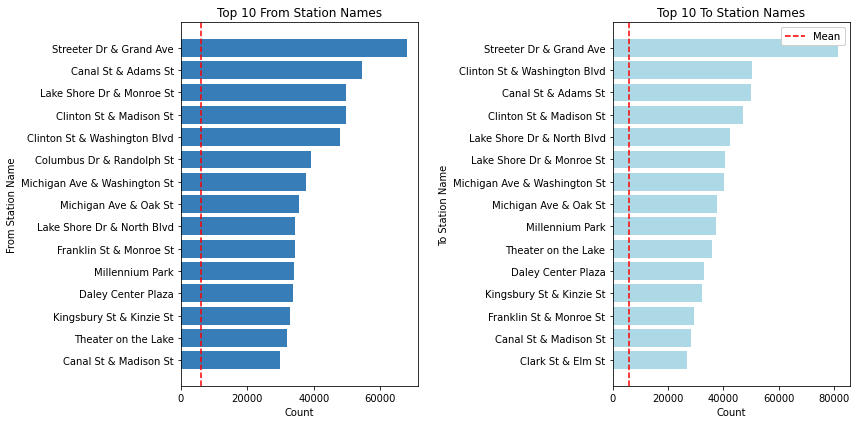

In [86]:
# Top 10 stations

# Calculate the counts of station names
from_station_counts = df['from_station_name'].value_counts()
to_station_counts = df['to_station_name'].value_counts()

# Get the top 15 station names and their counts
top_from_stations = from_station_counts.head(15)
top_to_stations = to_station_counts.head(15)

# Calculate the mean count for top stations
mean_from_station = from_station_counts.mean()
mean_to_station = to_station_counts.mean()

# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Define colors based on user type
set1_colors = sns.color_palette('Set1')

# Plot the horizontal bar chart for from_station_name
axs[0].barh(top_from_stations.index[::-1], top_from_stations.values[::-1], color=set1_colors[1])
axs[0].axvline(x=mean_from_station, color='red', linestyle='--', label='Mean')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('From Station Name')
axs[0].set_title('Top 10 From Station Names')

# Plot the horizontal bar chart for to_station_name
axs[1].barh(top_to_stations.index[::-1], top_to_stations.values[::-1], color='lightblue')
axs[1].axvline(x=mean_to_station, color='red', linestyle='--', label='Mean')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('To Station Name')
axs[1].set_title('Top 10 To Station Names')

# Add a legend for the red dashed line
legend = axs[1].legend(handles=[plt.Line2D([0], [0], color='red', linestyle='--', label='Mean')], loc='upper right')
axs[1].add_artist(legend)

plt.tight_layout()

plt.show()

<ipython-input-87-9c8d290a3af4>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1f}M'.format(x/1e6) for x in ax.get_xticks()])


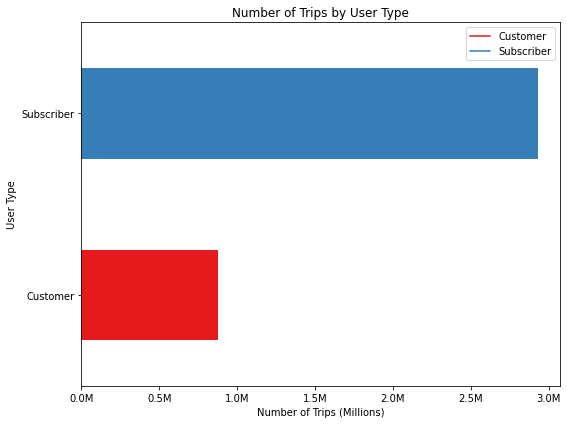

In [87]:
# Count the number of trips by user_type
user_type_counts = df['user_type'].value_counts().sort_values(ascending=True)

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bar chart for user_type
user_type_counts.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Number of Trips (Millions)')  # Add units to x-axis label
ax.set_ylabel('User Type')
ax.set_title('Number of Trips by User Type')

# Convert x-axis labels to millions with one decimal place
ax.set_xticklabels(['{:.1f}M'.format(x/1e6) for x in ax.get_xticks()])

# Get the color labels from the Seaborn color palette
color_labels = ['Customer', 'Subscriber']

# Create legend handles using the Seaborn color palette
handles = [plt.Line2D([0], [0], color=color, label=label) for color, label in zip(colors, color_labels)]

# Set the legend handles
ax.legend(handles=handles)

plt.tight_layout()
plt.show()

<ipython-input-88-6cb5aa47d92e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1f}M'.format(x/1e6) for x in ax.get_yticks()])


<Figure size 720x432 with 0 Axes>

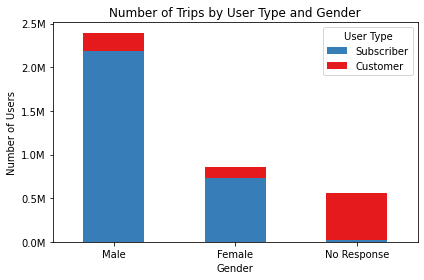

In [88]:
# Replace missing values with 'No Response'
df['gender'] = df['gender'].fillna('No Response')

# Create a pivot table for the counts
pivot_table = df.pivot_table(index='gender', columns='user_type', aggfunc='size', fill_value=0)

# Calculate the sum of each row (total users) and sort the rows
pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='Total', ascending=False)

# Ensure all desired columns are present
for col in ['Subscriber', 'Customer', 'Total']:
    if col not in pivot_table.columns:
        pivot_table[col] = 0

# Reorder columns
pivot_table = pivot_table[['Subscriber', 'Customer', 'Total']]

# Plot
plt.figure(figsize=(10, 6))

# Plot the stacked bar chart
ax = pivot_table.drop('Total', axis=1).plot(kind='bar', stacked=True)

plt.title('Number of Trips by User Type and Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.legend(title='User Type')

# Convert y-axis labels to millions with one decimal place
ax.set_yticklabels(['{:.1f}M'.format(x/1e6) for x in ax.get_yticks()])

# Set color palette using seaborn (for User Type)
#set1_colors = sns.color_palette('Set1')
reversed_colors = [set1_colors[1], set1_colors[0]]
sns.set_palette(reversed_colors)

plt.tight_layout()
plt.show()


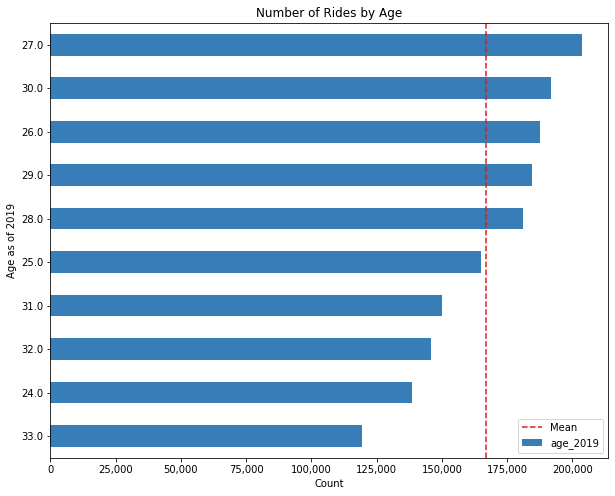

In [89]:
#### Check this chart and others for clearer naming
## Top Age

top_age = df['age_2019'].value_counts().head(10)

#set_colors
blue_color = set1_colors[1]  # Blue from Set1 palette
red_color = set1_colors[0]  # Red from Set1 palette

plt.figure(figsize=(10, 8))
top_age.plot(kind='barh', color=blue_color)
plt.title('Number of Rides by Age')
plt.xlabel('Count')
plt.ylabel('Age as of 2019')
plt.gca().invert_yaxis()

# Add mean line
mean_value = top_age.mean()
plt.axvline(x=mean_value, color=red_color, linestyle='dashed', label='Mean')
plt.legend()

# Format x axis
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


plt.show()

<Figure size 720x432 with 0 Axes>

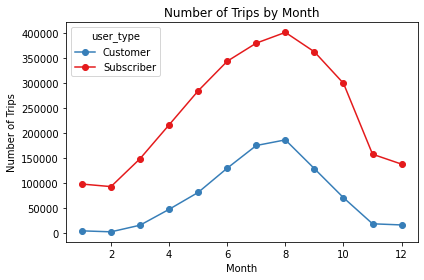

In [34]:
# Create month column
df['month'] = pd.to_datetime(df['start_time']).dt.month

# Group the data by month and user_type, then calculate the number of trips
trips_by_month_user_type = df.groupby(['month', 'user_type']).size().reset_index(name='num_trips')

# Pivot the data to create separate columns for 'Subscriber' and 'Customer' user types
pivot_table = trips_by_month_user_type.pivot_table(index='month', columns='user_type', values='num_trips', fill_value=0)

# Plot the data
plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o')
plt.title('Number of Trips by Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
#plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Modeling

In [35]:
# Create new target column where 1 equals subscriber and 0 equals not a subscriber
df['target'] = df['user_type'].apply(lambda x: 1 if x == 'Subscriber' else 0)

In [36]:
# dropping columns that will not be used in the modeling
columns_to_drop_modeling = ['month', 'from_station_name', 'to_station_name', 'user_type', 'start_time']
df.drop(columns=columns_to_drop_modeling, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3810119 entries, 0 to 3818003
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   from_station_id  int64  
 1   gender           object 
 2   age_2019         float64
 3   target           int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 145.3+ MB


In [37]:
# age_2019 and gender need to be imputed
df.isna().sum()

from_station_id         0
gender                  0
age_2019           538751
target                  0
dtype: int64

In [38]:
df['gender'].value_counts()

Male           2393966
Female          857050
No Response     559103
Name: gender, dtype: int64

In [39]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [40]:
# Function to impute 'No Response' values in the 'gender' column
def impute_gender_values(dataframe):
    # Calculate gender distribution of Male and Female excluding 'No Response'
    gender_distribution = dataframe[dataframe['gender'] != 'No Response']['gender'].value_counts(normalize=True)

    # Create function to impute null values based on known distribution
    def impute_gender(row):
        if pd.isnull(row['gender']) or row['gender'] == 'No Response':
            return np.random.choice(gender_distribution.index, p=gender_distribution.values)
        else:
            return row['gender']

    dataframe['gender_imputed'] = dataframe.apply(impute_gender, axis=1)

    # Male=1 and Female=0
    dataframe['gender_imputed'] = dataframe['gender_imputed'].replace({'Male': 1, 'Female': 0})
    
    return dataframe

# Apply the function to X_train_resampled and X_test
X_train_resampled = impute_gender_values(X_train)
X_test = impute_gender_values(X_test)

# drop previous gender column
X_train_resampled.drop(columns='gender', inplace=True)
X_test.drop(columns='gender', inplace=True)

In [41]:
print('X_train value counts:')
print(X_train['gender_imputed'].value_counts(normalize=True))

print('X_test value counts:')
print(X_test['gender_imputed'].value_counts(normalize=True))

print('df value counts:')
print(df[df['gender'] != 'No Response']['gender'].value_counts(normalize=True))

X_train value counts:
1    0.736532
0    0.263468
Name: gender_imputed, dtype: float64
X_test value counts:
1    0.735864
0    0.264136
Name: gender_imputed, dtype: float64
df value counts:
Male      0.736375
Female    0.263625
Name: gender, dtype: float64


In [42]:
# Extract columns for imputing using MICE and mode
# chose mode over mean because the mode is more representative of Divvy users I've observed over 5 years
# mean weas about 35YRS and mode is 27YRS
train_age_2019 = X_train[['age_2019']]
test_age_2019 = X_test[['age_2019']]

# instantiate the imputer 
iterative_imputer = IterativeImputer(random_state=42, initial_strategy='most_frequent')

# Impute for training data
train_age_imputed = iterative_imputer.fit_transform(train_age_2019)
X_train['age_2019_imputed'] = train_age_imputed
X_train.drop(columns='age_2019', inplace=True)

# Impute for test data
test_age_imputed = iterative_imputer.transform(test_age_2019)
X_test['age_2019_imputed'] = test_age_imputed
X_test.drop(columns='age_2019', inplace=True)

In [43]:
print('X_train shape:')
print(X_train.shape)
print('y_train shape:')
print(y_train.shape)


print('X_test shape:')
print(X_test.shape)
print('y_test shape:')
print(y_test.shape)


X_train shape:
(2857589, 3)
y_train shape:
(2857589,)
X_test shape:
(952530, 3)
y_test shape:
(952530,)


In [49]:
# Instantiate SMOTE
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [50]:


# List of your feature columns
feature_columns = ['from_station_id', 'gender_imputed', 'age_2019_imputed']

# Combine X_train_resampled and y_train_resampled into a single DataFrame
df_resampled = pd.DataFrame(X_train_resampled, columns=feature_columns)
df_resampled['target'] = y_train_resampled

# Compute Pearson correlation for each feature with the target 'target'
correlations = df_resampled.corrwith(df_resampled['target']).drop('target')
print(correlations)


from_station_id     0.050525
gender_imputed      0.069097
age_2019_imputed    0.358061
dtype: float64


In [51]:
# Collect garabage
gc.collect()

113

In [52]:
# Set random state for models to test
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
}

In [53]:
def run_model_with_grid_search_and_cv(models, model_type, cmap, X, y, n_splits=3):
    metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Accuracy', 'Recall', 'F1 Score', 'Type', 'Runtime (minutes)'])

    # Hyperparameter grids for each model
    param_grids = {
        'LogisticRegression': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'max_iter': [100, 500, 1000]
        },
        'DecisionTree': {
            'max_depth': [None, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
    }

    # loop to run through models using gridsearch and Kfold
    for name, model in models.items():
        print(f'Running... {name} Model')

        # Record the start time
        start_time = time.time()
        classifier = model

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(classifier, param_grids[name], cv=KFold(n_splits=n_splits, shuffle=True, random_state=42), n_jobs=-1)
        grid_search.fit(X, y)

        # Print the best hyperparameters
        print(f'Best hyperparameters for {name}: {grid_search.best_params_}')

        # Perform k-fold cross-validation
        cross_val_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=KFold(n_splits=n_splits, shuffle=True, random_state=42))
        cross_val_mean = round(np.mean(cross_val_pred == y), 4)
        recall = recall_score(y, cross_val_pred, average='weighted')
        accuracy = accuracy_score(y, cross_val_pred)

        # Record the end time
        end_time = time.time()
        
        # Calculate the elapsed time in minutes
        elapsed_time_minutes = round((end_time - start_time) / 60, 2)  # dividing by 60 to convert seconds to minutes and rounding off to 2 decimal places

        print(f'Runtime for {name} Model: {elapsed_time_minutes} minutes\n')

        metric_table = metric_table.append({'Model': name,
                                            'CV Score': cross_val_mean,
                                            'Accuracy': accuracy,
                                            'Recall': round(recall, 4),
                                            'Type': model_type,
                                            'Runtime (minutes)': elapsed_time_minutes},
                                           ignore_index=True)

        # print key stats
        print(f'Cross Validation Score: {cross_val_mean}')
        print(f'Accuracy Score: {accuracy}')
        print(f'Recall: {round(recall, 4)}\n')

        print(f'Classification Report for {name} Model:')
        print(classification_report(y, cross_val_pred))

        # Plot the confusion matrix with a heatmap
        fig, ax = plt.subplots()
        sns.heatmap(confusion_matrix(y, cross_val_pred, normalize='true'), annot=True, fmt=".2f", cmap=cmap)

        plt.title(f'{model_type} {name} Confusion Matrix')
        plt.grid(False)
        plt.show()

    # Sort the metric table by recall scores in descending order
    metric_table.sort_values(by='Recall', ascending=False, inplace=True)

    return metric_table

Running... LogisticRegression Model
Best hyperparameters for LogisticRegression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}
Runtime for LogisticRegression Model: 0.82 minutes

Cross Validation Score: 0.7057
Accuracy Score: 0.7056943923000785
Recall: 0.7057

Classification Report for LogisticRegression Model:
              precision    recall  f1-score   support

           0       0.66      0.86      0.74   2197425
           1       0.80      0.55      0.65   2197425

    accuracy                           0.71   4394850
   macro avg       0.73      0.71      0.70   4394850
weighted avg       0.73      0.71      0.70   4394850



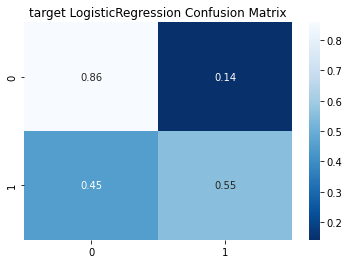

Running... DecisionTree Model
Best hyperparameters for DecisionTree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Runtime for DecisionTree Model: 0.64 minutes

Cross Validation Score: 0.8359
Accuracy Score: 0.8358667531315062
Recall: 0.8359

Classification Report for DecisionTree Model:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83   2197425
           1       0.82      0.86      0.84   2197425

    accuracy                           0.84   4394850
   macro avg       0.84      0.84      0.84   4394850
weighted avg       0.84      0.84      0.84   4394850



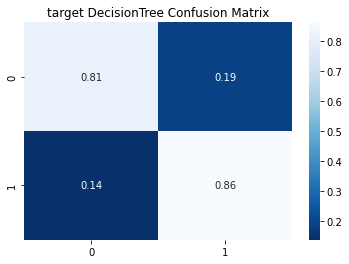

In [54]:
cmap = 'Blues_r'  

# Run the function on the data with k-fold cross-validation (n_splits=3)
metric_table_train = run_model_with_grid_search_and_cv(models, 'target', cmap, X_train_resampled, y_train_resampled, n_splits=3)

Test Cross Validation Score: 0.8712
Test Accuracy Score: 0.8712470998288768
Test Recall: 0.8712
Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70    220222
           1       0.90      0.93      0.92    732308

    accuracy                           0.87    952530
   macro avg       0.83      0.80      0.81    952530
weighted avg       0.87      0.87      0.87    952530



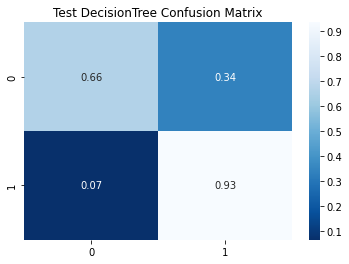

In [55]:
# Best hyperparameters for DecisionTree
best_hyperparameters = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

# Create a DecisionTreeClassifier instance with the best hyperparameters
best_decision_tree = DecisionTreeClassifier(**best_hyperparameters, random_state=42)

# Fit the model on the training data
best_decision_tree.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
test_predictions = best_decision_tree.predict(X_test)

# Calculate evaluation metrics on the test data
test_cross_val_pred = cross_val_predict(best_decision_tree, X_test, y_test, cv=KFold(n_splits=3, shuffle=True, random_state=42))
test_cross_val_mean = round(np.mean(test_cross_val_pred == y_test), 4)
test_recall = recall_score(y_test, test_cross_val_pred, average='weighted')
test_accuracy = accuracy_score(y_test, test_cross_val_pred)

# Print evaluation metrics
print(f'Test Cross Validation Score: {test_cross_val_mean}')
print(f'Test Accuracy Score: {test_accuracy}')
print(f'Test Recall: {round(test_recall, 4)}')

print('Test Classification Report:')
print(classification_report(y_test, test_cross_val_pred))

# Plot the confusion matrix with a heatmap for the test data
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, test_cross_val_pred, normalize='true'), annot=True, fmt=".2f", cmap=cmap)

plt.title('Test DecisionTree Confusion Matrix')
plt.grid(False)
plt.show()

Top Features:
            Feature  Importance
2  age_2019_imputed    0.781427
0   from_station_id    0.203374
1    gender_imputed    0.015199


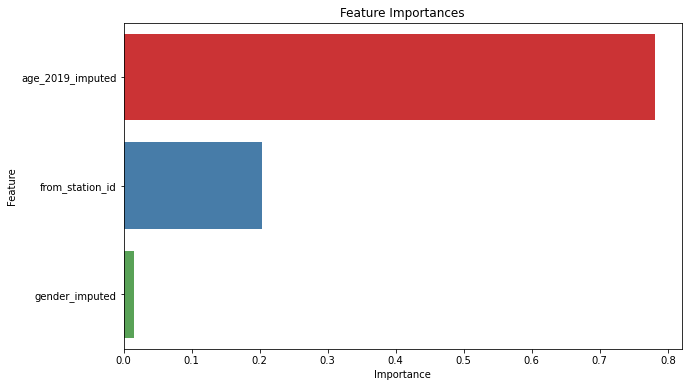

In [56]:
# Fit the model on the training data
best_decision_tree.fit(X_train_resampled, y_train_resampled)

# Extract feature importances
feature_importances = best_decision_tree.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top features and their importance scores
print('Top Features:')
print(feature_importance_df.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Set1')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Model Interpretation
Grid search was used to run two models with various parameters to determine the best model. The best performing model was the Decision Tree. The training data Decision Tree had a recall score of 0.84 compared to the Logistic Regression model that had a recall score of 0.71. The key metric for this analysis is recall because that will minimize the false negatives and maximize the true positives which will give us better performance on predicting Divvy Subscribers. The Decision Tree ran faster than the Logistic Regression and had better performance across all metrics. The most important feature in determining a Subscriber is by far the riders age which accounts for 78.1% of feature importance.

After training the model on the train data the overall recall improved and the model correctly identifies Subscribers 87.12% of the time. This is a first pass and we will need to add additional features and run more complex models to see if we can improve recall performance.


## Reccomendations
* Implement marketing plan to highlight Divvy in the downtown area.
* Offer discount rates to downtown offices.
* Highlight safe bike paths.


## Next Steps
* Run additional models with hardware that has adequate processing.
* Develop heat map of Chicago showing Divvy rides
* Expand the data set to include recent data.
* Analyze app reviews for consumer sentiment.
* Perform straw poll regarding Divvy safety sentiment.
* Evaluate station and bicycle conditions.

<div align="center">
    <img src="images/bike_sunset.jpg" width="450">
</div>